In [1]:
%load_ext cython
import cbclib as cbc
import numpy as np
import pyximport
from importlib import reload
import sys
import os
import h5py
import matplotlib.animation as animation
from tqdm.auto import tqdm
from cbclib.bin import *
from scipy import ndimage
from scipy.spatial import KDTree

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

pyximport.install(reload_support=True, build_in_temp=False,
                  build_dir='.pyxbld')

(None, <pyximport.pyximport.PyxImporter at 0x2b957589a470>)

In [2]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['ArrayWrapper', 'LSD', '__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__test__', 'draw_lines', 'maximum_filter', 'median_filter', 'np', 'subtract_background', 'tilt_matrix']


In [3]:
app = cbc.Qt.make_app()
w = cbc.Qt.ScatterViewer()
w.set_data(pos=np.random.rand(100, 3), size=3)
w.show()
app.exec_()

In [10]:
w.context()

# Streak detection

In [ ]:
scan_num = 209 # whitefield, 2s exposure
dir_path = '/asap3/petra3/gpfs/p11/2021/data/11010570/raw'

loader = cbc.CXILoader()
wf_data = cbc.converter_petra(dir_path, 209)
wf_data = wf_data.update_mask(method='range-bad', vmax=10000000)
whitefield = np.mean(wf_data.get('data') * wf_data.get('mask'), axis=0)
mask = np.any(wf_data.mask, axis=0)

Loading data:   0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
scan_num = 213 # B12 protein crystal, 1s exposure, 50 frames

data = cbc.converter_petra(dir_path, scan_num, mask=mask, roi=(1100, 3260, 1040, 3108),
                           pupil = (2150, 2300, 1900, 2030), whitefield=whitefield / 2)

Loading data:   0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
scan_num = 250 # Lysozyme crystal, 1s exposure, 101 x 4 x 4 frames

cxi_loader = cbc.CXILoader()
frame_idxs = np.arange(1 * 101, 2 * 101, 2)
dir_path = '/asap3/petra3/gpfs/p11/2021/data/11010570/raw'


wf_data = cbc.converter_petra(dir_path, scan_num, frame_idxs,
                              pupil=(2200, 2370, 1900, 2110))

wf_data.update_mask.inplace_update(method='range-bad', vmax=10000000)
wf_data.update_mask.inplace_update(method='perc-bad', update='multiply')

wf_data.whitefield = np.mean(wf_data.get('data') * wf_data.get('mask'), axis=0)
wf_data.mask = np.tile(np.any(wf_data.mask, axis=0)[None, ...], (wf_data.data.shape[0], 1, 1))

Loading data:   0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
cxi_loader = cbc.CXILoader.import_default(policy={'whitefield': True})

wf_data = cxi_loader.load('results/scan_250_whitefield.h5')

Loading data:   0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
dir_path = '/asap3/petra3/gpfs/p11/2021/data/11010570/raw'
scan_num = 250
frame_idxs = np.arange(10 * 101, 11 * 101)

data = cbc.converter_petra(dir_path, scan_num, frame_idxs, mask=wf_data.mask[0],
                           whitefield=wf_data.whitefield,
                           pupil=(2200, 2370, 1900, 2110), roi=(700, 3660, 640, 3508))

Loading data:   0%|          | 0/101 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


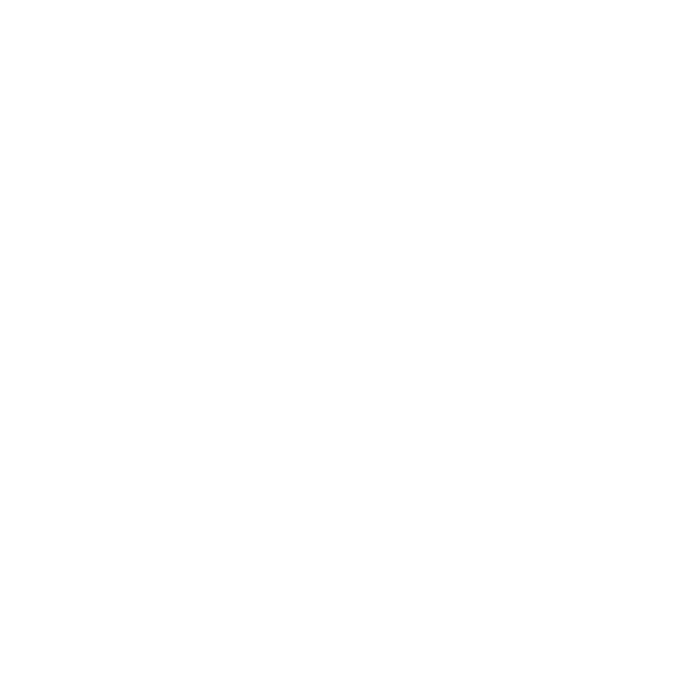

In [ ]:
%matplotlib notebook
frame_idx = 33

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
# ax.imshow(wf_data.get('data')[frame_idx] * wf_data.get('mask')[frame_idx], vmax=3)
# ax.imshow(data.get('data')[frame_idx] * data.get('mask')[frame_idx], vmax=3)
ax.imshow(data.get('cor_data')[frame_idx], vmin=0.3, vmax=3)
# ax.imshow(det_obj.streak_data[frame_idx], vmin=0, vmax=1)
plt.tight_layout()
plt.show()

In [ ]:
det_obj = cbc.StreakDetector.import_data(data, 0.2, 3., (1, 3, 3))
det_obj = det_obj.update_lsd(quant=1.8e-2)

In [ ]:
%time det_obj.update_mask.inplace_update(dilation=8)
%time det_obj.update_streak_data.inplace_update(iterations=4)

CPU times: user 3min 44s, sys: 10.9 s, total: 3min 54s
Wall time: 5.09 s
CPU times: user 1min 5s, sys: 12.2 s, total: 1min 17s
Wall time: 14.1 s


In [ ]:
data.update_streaks(det_obj)

In [ ]:
with h5py.File('results/scan_250_proc.h5', 'w') as cxi_file:
    data.write_cxi(cxi_file)

<IPython.core.display.Javascript object>


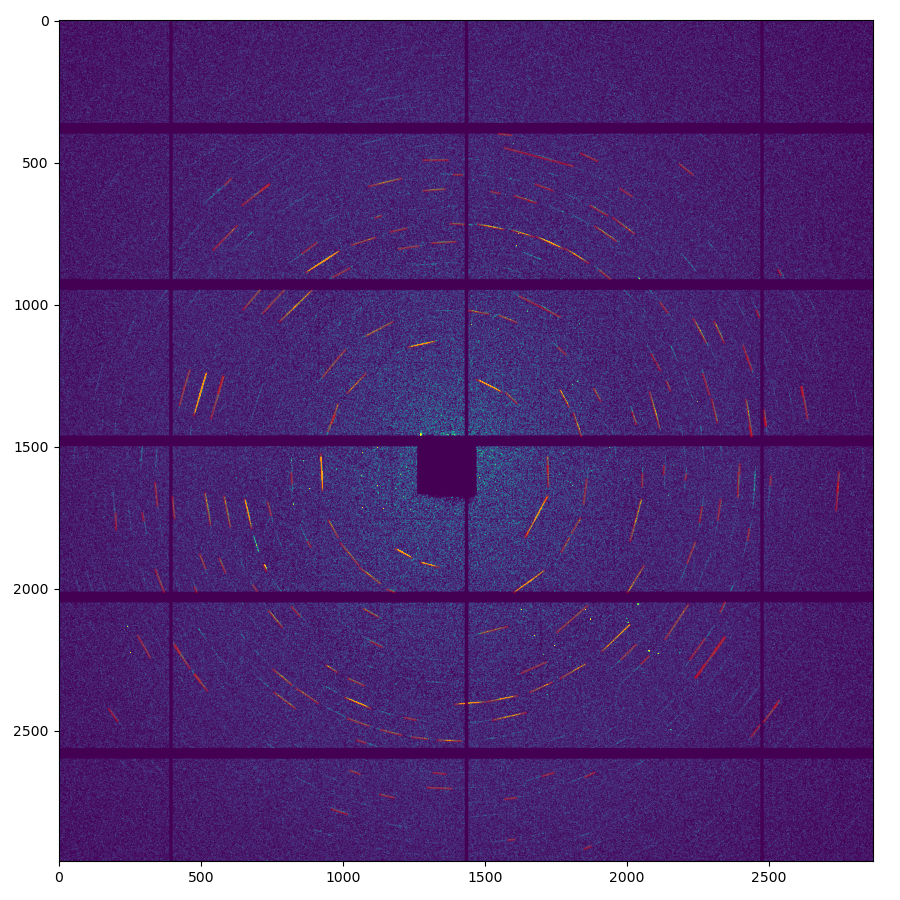

In [ ]:
%matplotlib notebook
frame_idx = 33

fig, ax = plt.subplots(1, 1, figsize=(9, 9))
ax.imshow(data.get('cor_data')[frame_idx], vmax=3)
# ax.imshow(det_obj.streak_data[frame_idx], vmax=1)
# ax.scatter(det_obj.center[1], det_obj.center[0], s=100)
for line in det_obj.streaks[frame_idx]:
    ax.plot(line[:4:2], line[1:4:2], c='r', alpha=0.4)

plt.tight_layout()
plt.show()

# Experimental geometry

In [ ]:
log_prt = cbc.LogProtocol()
cxi_loader = cbc.CXILoader()

foc_z = -0.012028122 # From PXST
dir_path = '/asap3/petra3/gpfs/p11/2021/data/11010570/raw'
h5_dir = os.path.join(dir_path, 'scan_frames/Scan_253')
log_path = os.path.join(dir_path, 'server_log/Scan_logs/Scan_253.log')
h5_files = sorted([os.path.join(h5_dir, path) for path in os.listdir(h5_dir)
                   if path.endswith(('LambdaFar.nxs', '.h5')) and not path.endswith('master.h5')])
h5_master = [os.path.join(h5_dir, path) for path in os.listdir(h5_dir)
             if path.endswith('master.h5')][0]

defocus = log_prt.load_attributes(log_path)['Session logged attributes']['z_sample'] - foc_z
x_pixel_size = cxi_loader.load_attributes(h5_master)['x_pixel_size']
y_pixel_size = cxi_loader.load_attributes(h5_master)['y_pixel_size']
wl = 2.0664032162696132e-11 # 60 keV

In [ ]:
pupil = np.array([2210, 2345, 1957, 2090])
pupil_2 = np.array([2214, 2400, 1974, 2155])
db = np.array([2171, 1913])
db_2 = np.array([2159, 1913])

det_dist_2 = 0.15 / (1.0 - 0.718) # sample-to-detector distance for scan 254
det_dist = det_dist_2 - 0.15 # sample-to-detector distance for scan 253

center = db + np.mean(((pupil - np.repeat(db, 2)) * defocus / det_dist).reshape((2, 2)), axis=1)
center_2 = db_2 + np.mean(((pupil_2 - np.repeat(db_2, 2)) * defocus / det_dist_2).reshape((2, 2)), axis=1)
tilt_shift = np.arange(4362)**2 / 2159**2 * 12.0 # Y_253 = Y_254 + tilt_shift[Y_254]
center[0], center_2[0] + tilt_shift[int(center_2[0])]

(2172.642544367827, 2172.650023383126)

In [ ]:
smp_pos = np.array([center[1] * x_pixel_size,
                    center[0] * y_pixel_size, det_dist])
foc_pos = np.array([db[1] * x_pixel_size, db[0] * y_pixel_size, det_dist + defocus])
scan_setup = cbc.ScanSetup(smp_pos=smp_pos, foc_pos=foc_pos, rot_axis=np.array([0.0, 1.0, 0.0]),
                           wavelength=wl, x_pixel_size=x_pixel_size, y_pixel_size=y_pixel_size)

In [ ]:
with open('results/exp_geom_248_253.ini', 'w') as ini_file:
    scan_setup.export_ini().write(ini_file)

In [ ]:
smp_pos_2 = np.array([center_2[1] * x_pixel_size,
                      center_2[0] * y_pixel_size, det_dist_2])
foc_pos_2 = np.array([db_2[1] * x_pixel_size, db_2[0] * y_pixel_size, det_dist_2 + defocus])
scan_setup_2 = cbc.ScanSetup(smp_pos=smp_pos_2, foc_pos=foc_pos_2, rot_axis=np.array([0.0, 1.0, 0.0]),
                             wavelength=wl, x_pixel_size=x_pixel_size, y_pixel_size=y_pixel_size)

In [ ]:
with h5py.File('results/scan_250_proc.h5', 'r') as cxi_file:
    whitefield = cxi_loader.read_cxi('whitefield', cxi_file)
    mask = cxi_loader.read_cxi('mask', cxi_file)[0]

In [ ]:
scan_num = 224 # Det dist = 20 cm
data = cbc.converter_petra(dir_path, scan_num, mask=mask,
                           pupil=(2200, 2370, 1900, 2110),
                           roi=(1100, 3260, 1040, 3108),
                           whitefield=whitefield)

Loading data:   0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
scan_num = 225 # Det dist = 40 cm
data = cbc.converter_petra(dir_path, scan_num, mask=mask,
                           pupil=(2200, 2370, 1900, 2110),
                           roi=(1100, 3260, 1040, 3108),
                           whitefield=whitefield)

Loading data:   0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
scan_num = 253 # Det dist = 40 cm

data = cbc.converter_petra(dir_path, scan_num,
                           pupil=(2200, 2370, 1900, 2110),
                           roi=(1100, 3260, 1040, 3108))
data.data = np.sum(data.data, axis=0, keepdims=True)
data.good_frames = data.good_frames[[0]]
data = data.import_mask(mask, update='multiply')
data = data.import_whitefield(3.0 * whitefield)

Loading data:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
det_obj = cbc.StreakDetector.import_data(data, 0.2, 3., (1, 3, 3))
det_obj = det_obj.update_lsd(scale=0.9, sigma_scale=0.9, log_eps=0, ang_th=60, density_th=0.5, quant=1.5e-2)
det_obj = det_obj.update_mask(dilation=8)
det_obj = det_obj.update_streak_data(iterations=4)

In [ ]:
scan_num = 254 # Det dist = 55 cm
whitefield_2 = np.zeros(whitefield.shape, dtype=np.float64)
whitefield_2[29:, 41:] = whitefield[:-29, :-41]
mask_2 = np.ones(mask.shape, dtype=bool)
mask_2[29:, 41:] = mask[:-29, :-41]

data_2 = cbc.converter_petra(dir_path, scan_num,
                             pupil=(2140, 2450, 1900, 2200),
                             roi=(700, 3660, 640, 3508))

data_2.data = np.sum(data_2.data, axis=0, keepdims=True)
data_2.good_frames = data_2.good_frames[[0]]
data_2 = data_2.import_mask(mask * mask_2, update='multiply')
data_2 = data_2.import_whitefield(3.0 * whitefield)

Loading data:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
det_obj_2 = cbc.StreakDetector.import_data(data_2, 0.2, 3., (1, 3, 3))
det_obj_2 = det_obj_2.update_lsd(quant=2.8e-2)
det_obj_2 = det_obj_2.update_mask(dilation=8)
det_obj_2 = det_obj_2.update_streak_data(iterations=4)

<IPython.core.display.Javascript object>


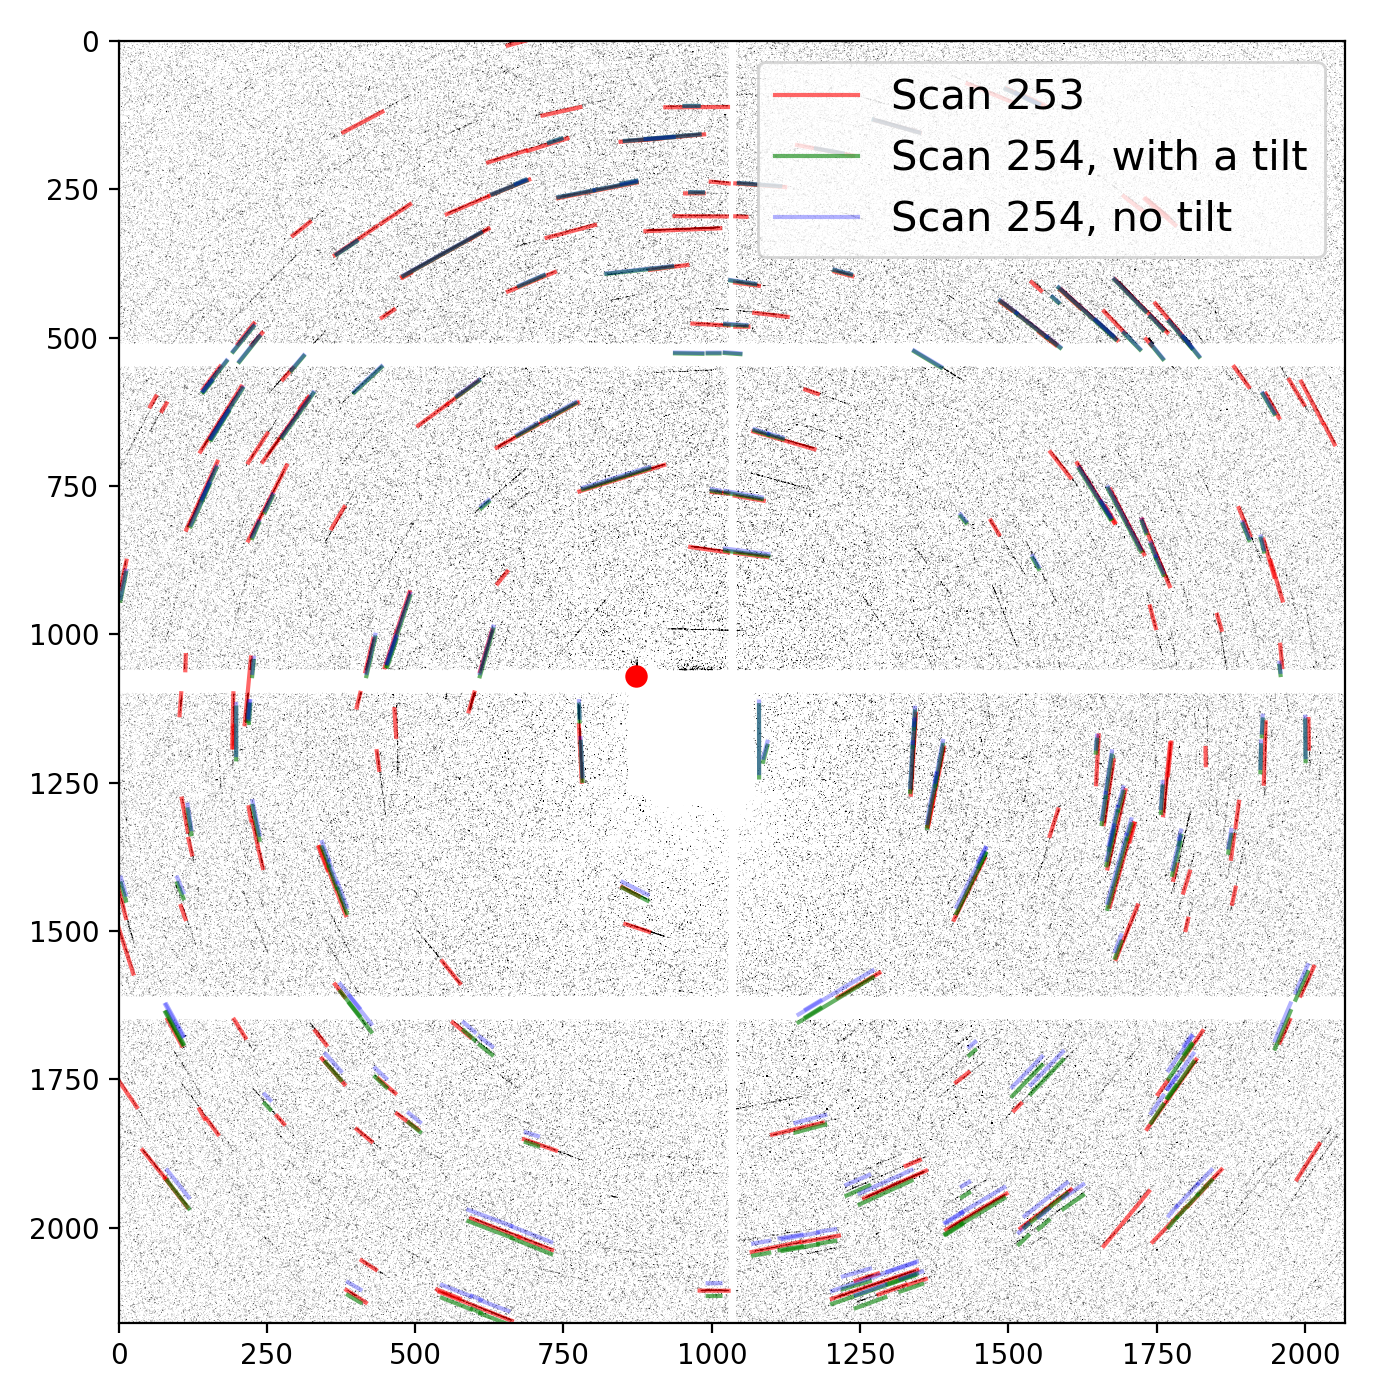

In [ ]:
%matplotlib notebook
frame_idx = 0
scale = 0.718


fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(data.get('cor_data')[frame_idx], vmin=0.2, vmax=3., cmap='gray_r')
for line in det_obj.streaks[frame_idx]:
    ln = ax.plot(line[:4:2], line[1:4:2], line[4], c='r', alpha=0.6)[0]
ln.set_label('Scan 253')
for line in det_obj_2.streaks[frame_idx]:
    ln = ax.plot((line[:4:2] + data_2.roi[2] - center[1]) * scale + center[1] - data.roi[2],
                 (line[1:4:2] + data_2.roi[0] - center[0]) * scale + center[0] - data.roi[0]
                 + tilt_shift[line[1:4:2].astype(int)], line[4], c='g', alpha=0.6)[0]
ln.set_label('Scan 254, with a tilt')
for line in det_obj_2.streaks[frame_idx]:
    ln = ax.plot((line[:4:2] + data_2.roi[2] - center[1]) * scale + center[1] - data.roi[2],
                 (line[1:4:2] + data_2.roi[0] - center[0]) * scale + center[0] - data.roi[0],
                 line[4], c='b', alpha=0.3)[0]
ln.set_label('Scan 254, no tilt')
ax.scatter(1913 - data.roi[2], 2159 + tilt_shift[2159] - data.roi[0], s=50, c='r')
ax.set_xlim(0, data.roi[3] - data.roi[2])
ax.set_ylim(data.roi[1] - data.roi[0], 0)
ax.legend(fontsize=15)
plt.tight_layout()
plt.savefig('figures/scan_253_254.jpg', dpi=300)

<IPython.core.display.Javascript object>


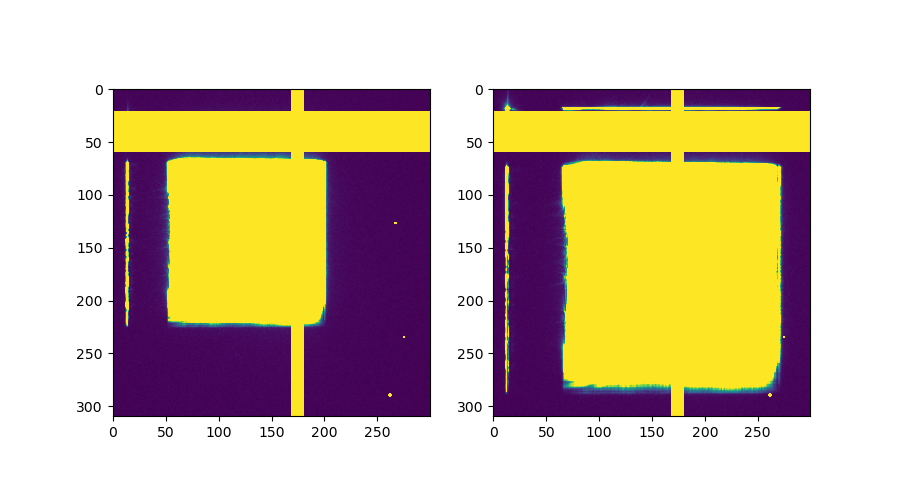

In [ ]:
%matplotlib notebook

fig, ax = plt.subplots(1, 2, figsize=(9, 5))
ax[0].imshow(data.data[2, 2140:2450, 1900:2200], vmax=500)
ax[1].imshow(data_2.data[2, 2140:2450, 1900:2200], vmax=500)
plt.show()

In [ ]:
smp_pos = [0.15 / (1.0 - 0.718)

0.5319148936170212

<IPython.core.display.Javascript object>


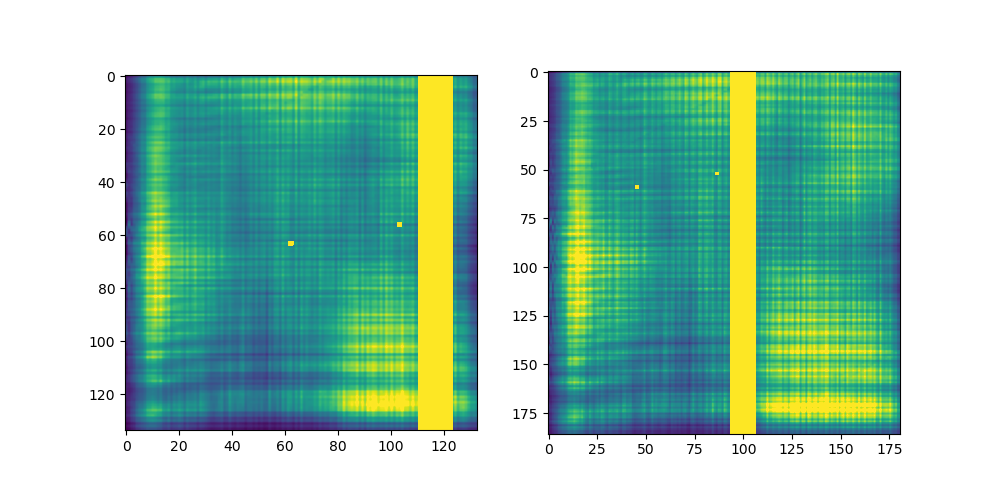

In [ ]:
%matplotlib notebook

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(data.data[0, 2210:2344, 1957:2090], vmax=300000)
ax[1].imshow(data_2.data[0, 2214:2400, 1974:2155], vmax=150000)
plt.show()

# CBC Indexing

In [ ]:
scan_setup = cbc.ScanSetup.import_ini('results/exp_geom_248_253.ini')
cxi_loader = cbc.CXILoader.import_default(policy={'cor_data': True, 'pupil':True,
                                                  'streak_data': True, 'streaks': True,
                                                  'whitefield': True})

data = cxi_loader.load('results/scan_250_proc.h5')

Loading data:   0%|          | 0/101 [00:00<?, ?it/s]

In [ ]:
%matplotlib notebook
import matplotlib.animation as animation
plt.rcParams['animation.ffmpeg_path'] = '/gpfs/cfel/user/nivanov/.conda/envs/pyrost/bin/ffmpeg'

fig, axes = plt.subplots(1, 1, figsize=(8, 8))
axes.set_xlabel('x coordinate, um', fontsize=15)
axes.set_ylabel('y coordinate, um', fontsize=15)
axes.tick_params(labelsize=15)

im_0 = axes.imshow(data.get('data')[0] * data.get('mask')[0], vmin=0, vmax=3,
                   extent=[data.roi[2] * scan_setup.x_pixel_size,
                           data.roi[3] * scan_setup.x_pixel_size,
                           data.roi[1] * scan_setup.y_pixel_size,
                           data.roi[0] * scan_setup.y_pixel_size])
axes.set_title('Frame 0', fontsize=20)
fig.tight_layout()

def update(iternum): 
    im_0.set_data(data.get('data')[iternum] * data.get('mask')[iternum])
    axes.set_title(f'Frame {iternum:d}', fontsize=20)
    return im_0, 

ani = animation.FuncAnimation(fig, update, frames=data.good_frames.size, interval=200, blit=True)
    
FFwriter = animation.FFMpegWriter(extra_args=['-vcodec', 'libx264'])
# ani.save('figures/scan_250.mp4', writer=FFwriter)
plt.show()

<IPython.core.display.Javascript object>

In [ ]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['ArrayWrapper', 'LSD', '__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__test__', 'draw_lines', 'maximum_filter', 'median_filter', 'np', 'subtract_background', 'tilt_matrix']


<IPython.core.display.Javascript object>


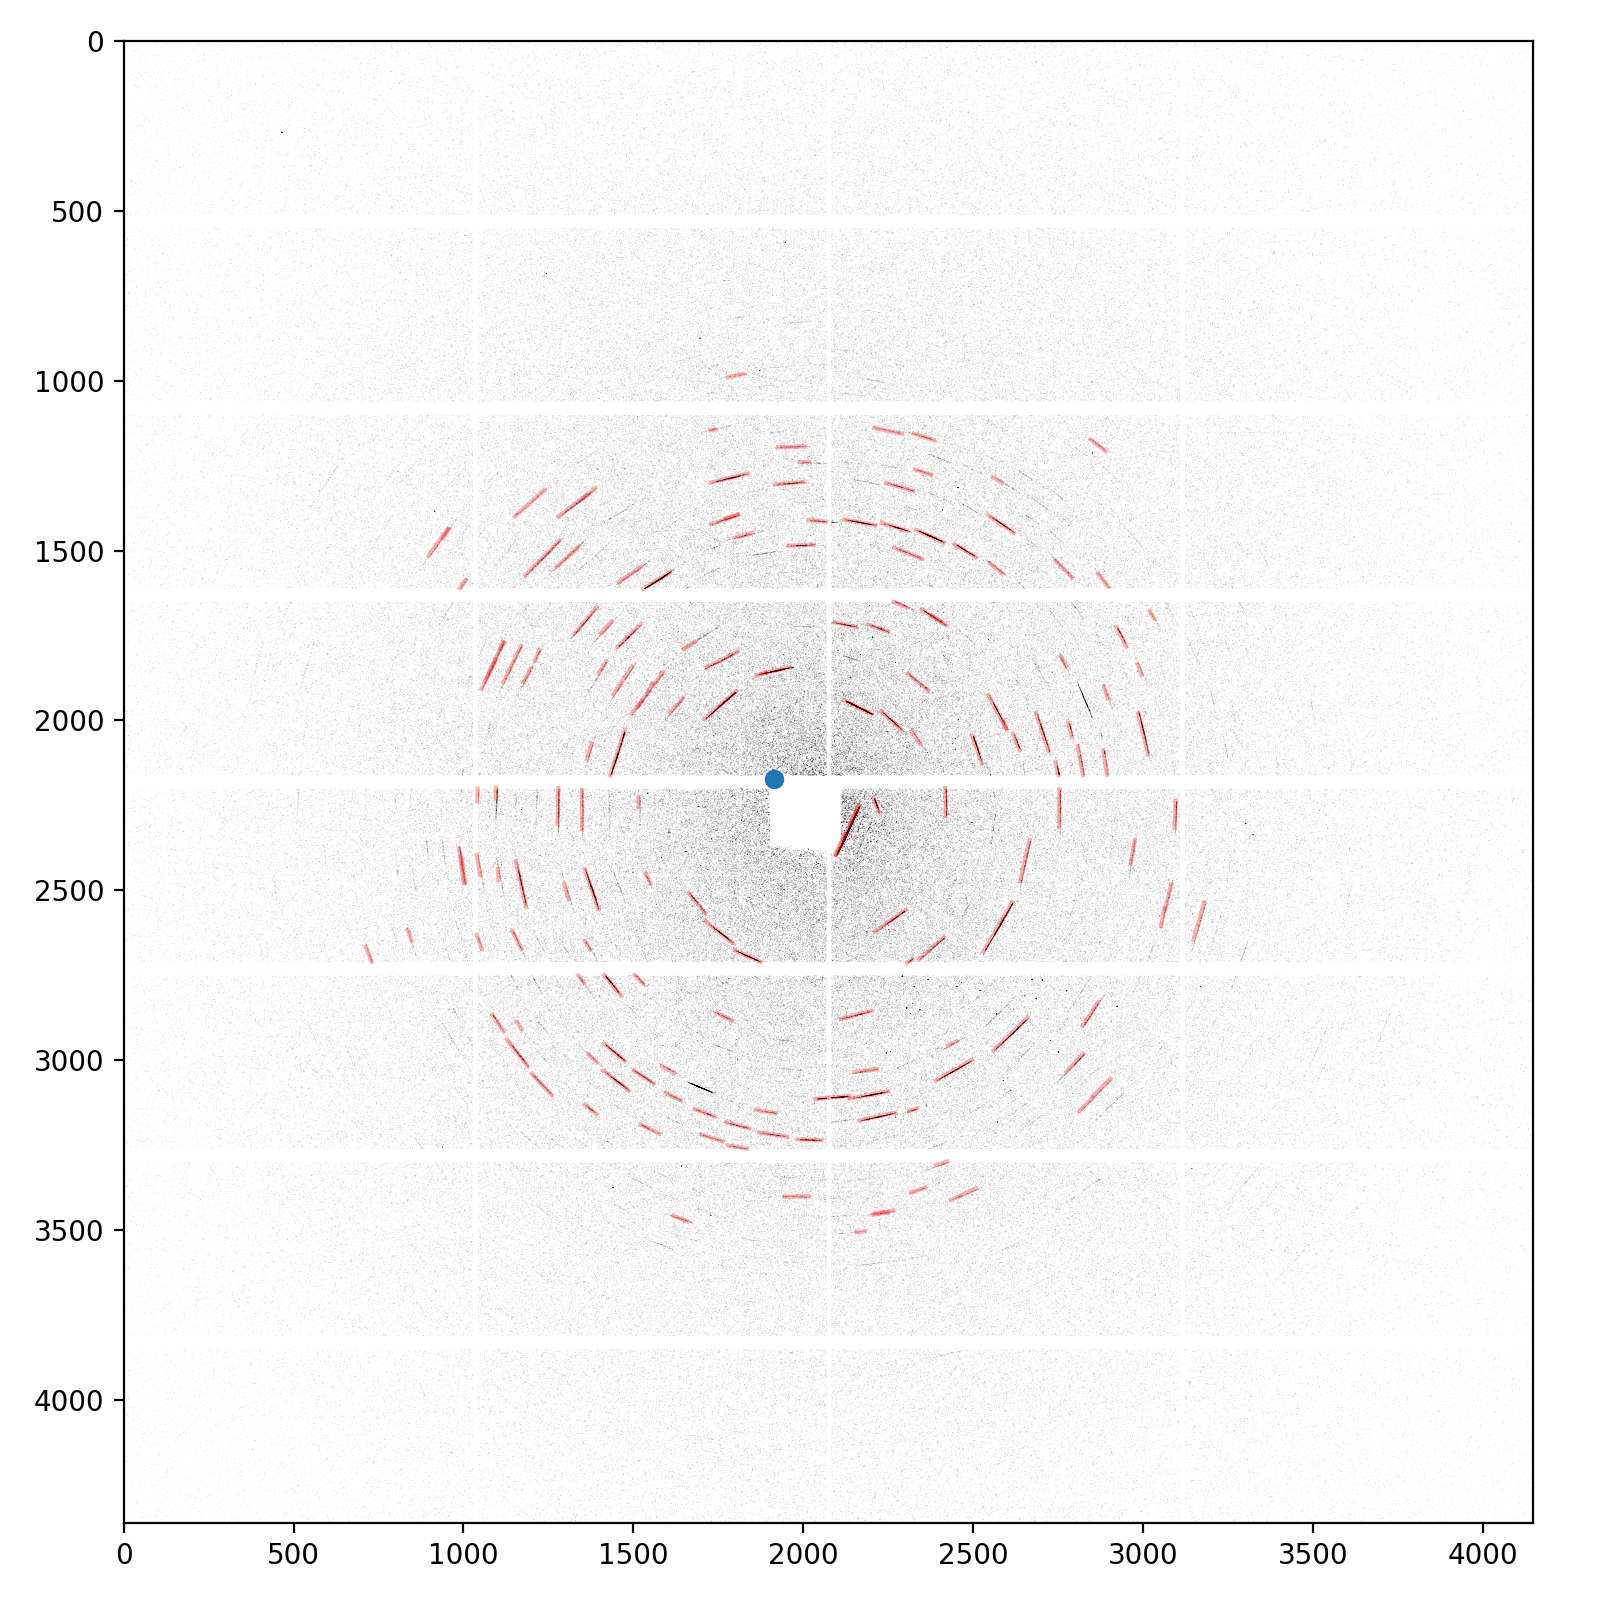

In [ ]:
%matplotlib notebook
frame_idx = 0

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(data.cor_data[frame_idx], cmap='gray_r', vmin=0.2, vmax=3.0)
for line in data.streaks[frame_idx]:
    ax.plot(line[:4:2], line[1:4:2], c='r', alpha=0.3)
ax.scatter(scan_setup.smp_pos[0] / scan_setup.y_pixel_size, 
           scan_setup.smp_pos[1] / scan_setup.x_pixel_size)
fig.tight_layout()
plt.show()

In [ ]:
tilt_mats = scan_setup.tilt_matrices(-data.tilts)
kin = {idx: np.tile([[[0., 0., 1.]]], (streaks.shape[0], 2, 1)).dot(tilt_mats[idx])
       for idx, streaks in data.streaks.items()}
kout = {idx: scan_setup.detector_to_kout(streaks).dot(tilt_mats[idx])
        for idx, streaks in data.streaks.items()}
scat_vec = {idx: kout[idx] - kin[idx] for idx in data.streaks}

<IPython.core.display.Javascript object>


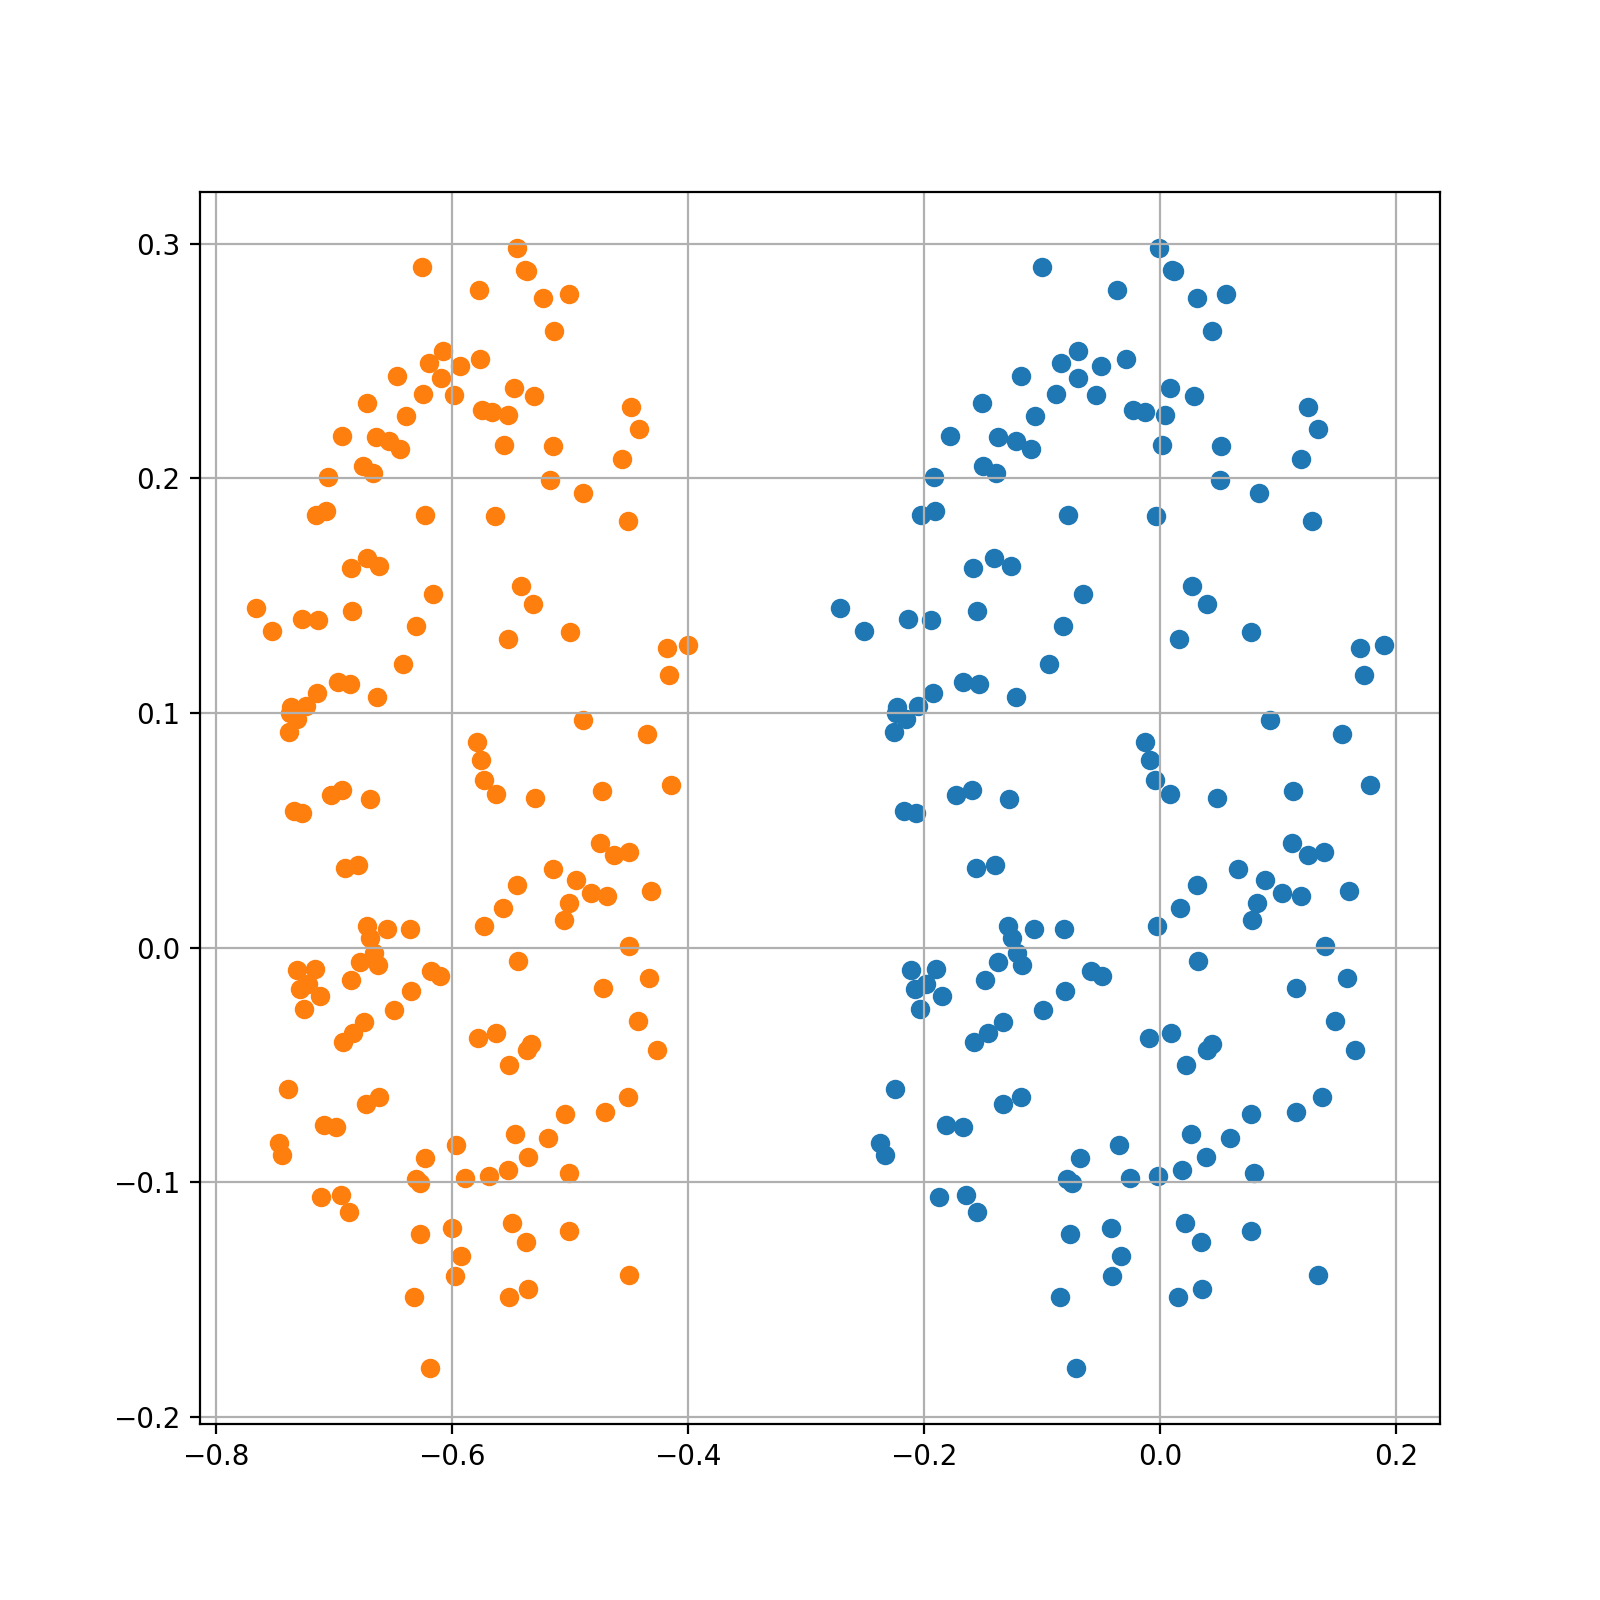

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8, 8))
idx0 = 0
idx1 = 10

ax.scatter(scan_setup.detector_to_kout(data.streaks[idx0]).mean(axis=1)[..., 0],
           scan_setup.detector_to_kout(data.streaks[idx0]).mean(axis=1)[..., 1])
ax.scatter(scan_setup.detector_to_kout(data.streaks[idx0]).mean(axis=1).dot(tilt_mats[idx0])[..., 0],
           scan_setup.detector_to_kout(data.streaks[idx0]).mean(axis=1).dot(tilt_mats[idx0])[..., 1])
# ax.scatter(scan_setup.detector_to_kout(data.streaks[idx1]).mean(axis=1)[..., 0],
#            scan_setup.detector_to_kout(data.streaks[idx1]).mean(axis=1)[..., 1])
ax.grid(True)
plt.show()

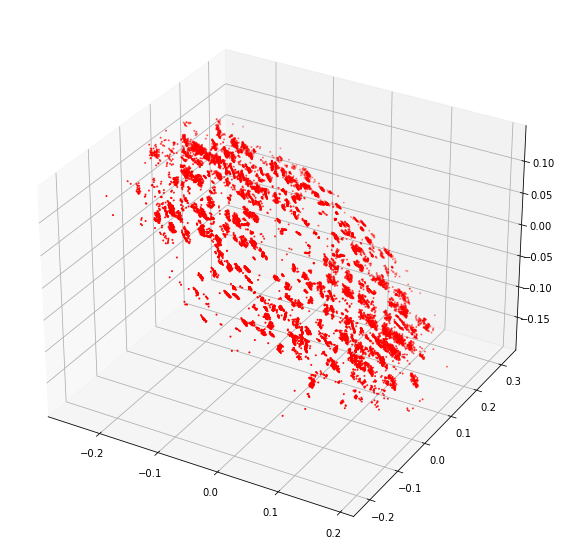

In [ ]:
%matplotlib inline
idx = 0

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for idx in scat_vec:
    ax.scatter(scat_vec[idx].mean(axis=1)[..., 0],
               scat_vec[idx].mean(axis=1)[..., 1],
               scat_vec[idx].mean(axis=1)[..., 2], c='r', s=1)

plt.show()